# Main sandbox for R&D the dataset

## Initialization
<p> All imports goes here </p>

In [1]:
import pandas as pd
import osmnx as ox
import folium
import geopandas as gpd
from shapely.geometry import Point, Polygon

ox.config(log_console=True, use_cache=True)

/tmp/ipykernel_239500/1809239200.py:7: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(log_console=True, use_cache=True)


## Raw Data Visualization
<p> First off we are going to take a peek at data on the map and see what we are dealing with </p>

In [2]:
# Reading the given csv file
coord_df = pd.read_csv("../data/rides-data.csv", index_col=0).reset_index(drop=True)
coord_df

,id,origin_lat,origin_lng,destination_lat,destination_lng
0,8050084674,35.769844,51.366798,35.761581,51.403202
1,8055547548,35.698536,51.490612,35.658817,51.397949
2,8052893242,35.729149,51.554649,35.742706,51.565334
3,8067231026,35.685909,51.419937,35.745754,51.420338
4,8051092783,35.742085,51.438961,35.603508,51.400173
...,...,...,...,...,...
99995,8074092556,35.787411,51.503502,35.795544,51.498772
99996,8064670176,35.763897,51.348629,35.775799,51.347256
99997,8050188722,35.685860,51.414677,35.784729,51.353745
99998,8071806219,35.738853,51.467167,35.745167,51.398777


### Reshaping the data for viewing.
<p> At first glance we don't need the type of the coordinates (Origin, Destination) as so if people are going to the crowded places, namely, universities and malls they probably are going to also use Snapp to get back. So overall we want to see the density over these places whether they are going to them or coming from them </p>

In [3]:
# Reshaping the DataFrame
df_long = pd.melt(
    coord_df,
    id_vars=["id"],
    value_vars=["origin_lat", "origin_lng", "destination_lat", "destination_lng"],
    var_name="type",
    value_name="coordinate",
)

# Split 'type' into two columns 'location_type' and 'coord_type'
df_long["location_type"] = df_long["type"].apply(lambda x: x.split("_")[0])
df_long["coord_type"] = df_long["type"].apply(lambda x: x.split("_")[1])

# Pivot the table to get 'lat' and 'long' in separate columns
df_points = df_long.pivot_table(
    index=["id", "location_type"],
    columns="coord_type",
    values="coordinate",
    aggfunc="first",
).reset_index()

# Rename columns for clarity
df_points.columns = ["id", "coord_type", "lat", "long"]

df_points.to_csv("../data/exploded_rides_data.csv")

<p> So by looking at map specially the places mentioned in the hint part we see that there is a high density of points there. We can assume that the task of finding entrances of these crowded places is an unspervised learning problem,
specifcally we need clustering mecahnism for points around these and the centroids of the clusters probably can give us a good estimates on the entrances. </p>

## Finding Entrances

<p>
So now we want to try and find the entrances of these places mentioned in the hint part. Let's sit back and think a little about how we can do so. As mentioned we want to perform clustering on the data.
But before doing so on which points should we do the clustering?

The obvious exlusion is that we should not use all available points to us, because doing so leads to great error. Also not only malls and universities are crowded. There are other crowded places like squares (Enghelab, Azadi), intersections (valiasr) and more which don't have entrances.

So first we need to filter the points. But how can we do so?

One solution that comes to mind is to find the center of the place and then set a radius for example 100 meters and filter the points from the rides using this and then perform clustering.

There is a princial flaw to this method: The circle we choose as boundary may not contain relevent points or worst case any points at all depending on the structure of the place.
Let's illustrate this by some images.

<img src="../images/bad-boundary1.svg" width="400" height="400">
<br>
<small>Bad Boundary Example: The building is too long and the circle boundary does not contain relevent points</small>
<br><br>
<img src="../images/bad-boundary2.svg" width="400" height="400"><br>
<small>Bad Boundary Example. The center is outside the building structure itself.</small>

We may increase the 100 meters radius mentioned but this may lead to finding extra points that not relevent to that specific place, like if two malls are close to each other if the defined radius threshold is too high the boundary of one mall may contain points from other mall (Near San'at square exists several malls that are near each other like Setin, Milad Noor and Lidoma) and that leads to error in clustering.

Also some points that are inside of the building gets included by this approach (entrances are not placed inside a place).
As you see this method will not work for this case.

So what other options do we have?

How about choosing points that reside at the boundries of the place with a certain distance (Buffered Polygon)?
This is a more intuitive and logical approach as it is shape-agnostic and does not depened on the structure of the building. Also it reduces the chance of overlapping for places that are near each other (This of course needs a good distance value from polygon boundaries and is a heuristic that needs to be calculated carefully).
Another merit of this approach is that it does not contain the points inside of the building.<br>
<b>NOTE:</b> By looking at the points visualization there are not many points inside of a building and these can probably be removed using outlier detection methods, but this is prone to error and buffered polyon can be assumed as a safer and more accurate approach.


So overall by using this we can filter more accurate points that can be used in clustering for finding entrances.


<img src="../images/iranmall-buffer.png" width="488" height="348">
<br>
<small>Buffered Iran Mall Region</small>

So to summarize we discussed two methods for point filtering:
<ul>
    <li>
        <b>Circular Boundary From The Center</b><br>
        <small>Disadvantages</small>
        <ul>
            <li>May not contain all points</li>
            <li>May not contain any points at all</li>
            <li>May overlap with points of other places</li>
            <li>Contains points inside of a place</li>
        </ul>
        <small>Advantages</small>
        <ul>
            <li>Easy to implement and understand</li>
        </ul>
    </li>
    <li>
        <b>Buffered Polygon</b><br>
        <small>Disadvantages</small>
        <ul>
            <li>Harder to implement</li>
        </ul>
        <small>Advantages</small>
        <ul>
            <li>More intuitive</li>
            <li>Contains relevent points</li>
            <li>Exludes points inside of a place</li>
        </ul>
    </li>
</ul>
</p>


### Point Filtering
<p> Now let's dive into coding </p>

#### Finding polygons of places

In [ ]:
# Use a specific query to locate Iran Mall
# It's important to provide sufficient context in the query (like city or region)
# place_query = {"W": 175770954}
place_query = 'South Terminal, Tehran, Iran'


# # Fetch the geometries data
results = ox.features_from_place(place_query, tags={"place": True})
results
# ox.geocode_to_gdf("W320902874", by_osmid=True)
# results = ox.features_from_address(place_query, tags={'building': True})
# results
# ox.geocode_to_gdf("W175770954", by_osmid=True)


In [ ]:
# Obtained by searching through google maps and OSM results.
places_meta = [
    {"place": "Opal", "osm_query": "W498492266"},
    {"place": "Koroush", "osm_query": "W320902874"},
    {"place": "Iran Mall", "osm_query": "R8129683"},
    {"place": "Paladium", "osm_query": "W678453222"},
    {"place": "Mehr Abad", "osm_query": "W175770954"},
    {"place": "West Terminal", "osm_query": "W182016096"},
    {"place": "Imam Khomeini Hospital", "osm_query": "W191445129"},
    {"place": "Shariati Hospital", "osm_query": "W438148006"},
    {"place": "Technical Faculties of Tehran University", "osm_query": "W385628505"},
]

In [ ]:
# Define the location query
place_query = "Iran Mall, Tehran, Iran"

# Fetch geometries from OSM
# Adjusting the query might be necessary depending on how the data is tagged in OSM
iran_mall = ox.geocode_to_gdf("W498492266", by_osmid=True)
# gdf = ox.features_from_place(place_query, tags={'building': True})

# First, we need the centroid of the polygon to center our map
centroid = iran_mall.geometry.centroid.iloc[0]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Adding the polygon to the map
folium.GeoJson(iran_mall, name="Iran Mall").add_to(m)

# Optional: add a layer control to toggle layers
folium.LayerControl().add_to(m)

# Display the map
m.save("test_map.html")

In [ ]:
# Define the location query
place_query = "Iran Mall, Tehran, Iran"

# Fetch geometries from OSM
# Adjusting the query might be necessary depending on how the data is tagged in OSM
gdf = ox.features_from_place(place_query, tags={"building": True})

# Optionally filter to a specific entry, if necessary
iran_mall = gdf[gdf["name:en"] == "Iran Mall"]
# First, we need the centroid of the polygon to center our map
centroid = iran_mall.geometry.centroid.iloc[0]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Adding the polygon to the map
folium.GeoJson(iran_mall, name="Iran Mall").add_to(m)

# Optional: add a layer control to toggle layers
folium.LayerControl().add_to(m)

# Display the map
m.save("iran_mall_map.html")

In [54]:
# Define the location query
place_query = 'Iran Mall, Tehran, Iran'

# Fetch geometries from OSM
# Adjusting the query might be necessary depending on how the data is tagged in OSM
gdf = ox.geometries_from_place(place_query, tags={'building': True})

# Optionally filter to a specific entry, if necessary
iran_mall = gdf[gdf['name:en'] == 'Iran Mall']

# Ensure you have the correct geometry if multiple entries exist
iran_mall = iran_mall.iloc[0].geometry if not iran_mall.empty else None

# Check if Iran Mall was found and has valid geometry
if iran_mall is not None:
    # Convert to GeoDataFrame
    iran_mall_gdf = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[iran_mall])
    
    # Project to UTM zone appropriate for Tehran (for accurate distance measurements)
    iran_mall_gdf = iran_mall_gdf.to_crs(epsg=32639)  # UTM zone 39N
    
    # Buffer the geometry by 100 meters
    buffered_mall = iran_mall_gdf['geometry'].buffer(100)
    
    # Project back to WGS84 for mapping
    iran_mall_gdf = iran_mall_gdf.to_crs(epsg=4326)
    buffered_mall = buffered_mall.to_crs(epsg=4326)

    # Create the map centered on the centroid of the Iran Mall polygon
    centroid = iran_mall_gdf.geometry.centroid.iloc[0]
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)
    
    # Add the original polygon to the map
    folium.GeoJson(iran_mall_gdf, name="Iran Mall").add_to(m)
    
    # Add the buffered polygon to the map
    folium.GeoJson(buffered_mall, name="Buffered Iran Mall", style_function=lambda x: {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.1}).add_to(m)
    
    # Add layer control to toggle layers
    folium.LayerControl().add_to(m)
    
    # Display the map
    m.save('iran_mall_map.html')
    m
else:
    print("Iran Mall not found or has no valid geometry.")


/tmp/ipykernel_239500/1563827020.py:6: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place_query, tags={'building': True})
/tmp/ipykernel_239500/1563827020.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = iran_mall_gdf.geometry.centroid.iloc[0]


In [55]:

points_geodf = gpd.GeoDataFrame({'geometry': [Point(i["long"], i["lat"]) for i in df_points[["long","lat"]].to_dict("records")]}, crs="EPSG:4326")

# Convert polygons to GeoDataFrame for consistent operations
# polygons_df = gpd.GeoDataFrame({'geometry': [iran_mall_gdf, buffered_mall]}, crs="EPSG:4326")


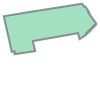

In [61]:
iran_mall_gdf["geometry"][0]

In [64]:
points_geodf['in_buffered'] = points_geodf.within(buffered_mall[0])
points_geodf['in_original'] = points_geodf.within(iran_mall_gdf["geometry"][0])
points_geodf[points_geodf["in_buffered"] == True]
points_geodf[(points_geodf['in_buffered']) & (~points_geodf['in_original'])]

,geometry,in_buffered,in_original
43,POINT (51.19345 35.75567),True,False
725,POINT (51.19294 35.75563),True,False
2478,POINT (51.19294 35.75573),True,False
2502,POINT (51.19156 35.75572),True,False
2576,POINT (51.19163 35.75554),True,False
...,...,...,...
198893,POINT (51.19163 35.75554),True,False
199279,POINT (51.19294 35.75573),True,False
199477,POINT (51.19196 35.75570),True,False
199507,POINT (51.19294 35.75573),True,False
